## Insights from results

### Insights from Model 1
- Increasing the training samples did not improve the score that much (Re-run with small sample just to check though)
- train: 166159 -> comp_metric at ~ 27 
- train: 536 -> comp_metric at ~ 43.7 (rmse_x: 37.69673776033537 rmse_y: 21.840938110932335 rmse_f: 0.696238586518948)
- For MLP, RMSE was better when trained with 536 samples, at about ~22.4 train loss (with 166159, it was ~ 62 train loss) -> is a prrof that 536 is just too small to be a sample
- Comp metric was way too bad for every model -> lowest was LGBM of ~27 (LB is ~4)
- LGBM has lower score than RF -> Sign of Overfit
- MLP had the worst score with lots of data, and best with small data
- The generated data is just rubbish

### Insights from Model 2
- Running the first 3 test models with n_estimators=1000 at max -> just to see the results quickly
- First run -> rmse_x: 0.85 rmse_y: 0.93 rmse_f: 0.0115 -> comp metric was at 0.97, which is amazing but took a look at feature importance -> it includes "file_id", indicating that most of the "filled" x and y values tend to be the same for many records, so something like file_id becomes a great predictor of x and y -> drop "file_id" and "file_id_le" as they cause leakage
- Second run w/o "file_id" -> rmse_x: 1.52 rmse_y: 1.69 rmse_f: 0.0161 -> comp metric was 1.63 -> more realistic -> timestamp features are in the top -> timestamps, especially "diff_start_wp_ts" is the predictor -> maybe drop timestamps? -> it's only that there aren't enough number of buildings and files that are covered by this training data -> maybe dropping these might enable us to see the "real" predictive power of the model -> but timestamps are included in the test txt files, so only drop "diff_start_wp_ts", which gives constant value with x/y/f -> leak
- Third run, drop "diff_start_wp_ts" -> rmse_x: 1.53 rmse_y: 1.73 rmse_f: 0.0148 -> comp metric was 1.68 -> other timestamps are still strong predictors -> maybe it's not just the timestamps that might be "acting like a leak"
- Fourth run, drop all the timestamp related columns -> to see the predictive power of numerical and categorical features only -> rmse_x: 2.57 rmse_y: 2.69 rmse_f: 0.0559 -> comp metric at 3.11 -> **beacon_ssid > wifi bssid > wifi ssid > wifi rssi > rel_x&rel_y > magn_u_x/y**

### First submission w/ Model 2
- Train lightgbm model that covers at least 3 files from each site_ids as the train data, and try creating prediction with full test data w/ 250ms timestamp cut -> rmse_x: 1.67 rmse_y: 1.98 rmse_f: 0.052 -> comp metric was 1.88 -> submission score was **86.070**, no where near the top of the leaderboard
- Re-train lgbm with same train data -> rmse_x: 0.58 rmse_y: 0.47 rmse_f: 0.00258 -> comp metric was 1.00 -> submission score was 130
- Re-train lgbm with same train data but after dropping all nan -> submission score was **83**, so it tells us that the "taking the closest datapoint" approach was garbage.
- Re-train with old format data (wps based timestamps) -> rmse_x: 31.5 rmse_y: 28.2 rmse_f: 0.9 -> comp metric at 43.1

### Takeaways
- Likely feature importances -> **beacon_ssid > wifi bssid > wifi ssid > wifi rssi > rel_x&rel_y > magn_u_x/y**
- Problem = multiple records expressing the same x/y/f, is the real problem here
- It doesn't mean "taking the closest waypoint" approach is wrong, it just needs to expressed/filled differently
- Maybe "Fill the gap" strategy needs to be changed from "taking the closest waypoint" to "fill it with averaging or other methods" because it would trigger leakage
- But sometimes "take the closest one" approach might be better. For example, beacon
- **Before we start working on improving the "fill the gap" strategy, we'll try it with test data and try submitting it on LB to see whether this is a valid strategy that we can pursue**

In [2]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

import math

pd.set_option("display.max_columns", 100)

In [3]:
!cp -r ../input/indoorlocationgithub/* ./

In [4]:
from io_f import read_data_file
from compute_f import compute_step_positions, compute_steps, \
compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

In [5]:
SEED = 42

In [6]:
# train_file_name = "../input/indoorfulltestgroupedtrain/indoor_train_2_site_group.pkl"
train_file_name = "../input/train3/indoor_train_3.pkl"
test_file_name = "../input/indoorfulltestgroupedtrain/indoor_test_2_250ms.pkl"
# dir_path = "../input/indoorpkl/"
# dir_path = "../input/indoorpkl/"

# Load data it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)

In [7]:
display(df_train.head())
display(df_test.head())

,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_100ms,within_200ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_acc,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,gyro_acc,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,acce_u_acc,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,magn_u_acc,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,gyro_u_acc,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5a0546857ecc773753327266,5e158ee71506f2000638fd15,-1.0,B1,1.578470e+12,1.578470e+12,11.0,162.76183,143.48042,NaN,NaN,NaN,NaN,NaN,1.578470e+12,136.0,-0.314484,5.835998,7.877106,NaN,1.578470e+12,136.0,0.310871,-0.013497,-0.098827,NaN,1.578470e+12,136.0,-7.362366,11.978149,-38.308716,NaN,40.807330,1.578470e+12,136.0,-0.089737,0.181778,0.392227,NaN,1.578470e+12,136.0,-0.216324,5.754593,7.984848,NaN,1.578470e+12,136.0,-14.569092,28.443909,-367.87567,NaN,1.578470e+12,136.0,-0.099670,0.185715,0.385239,NaN,1.578470e+12,1972.0,7c67c956ac9115e7bf481fdf26ef916c30a8a393,b7bcbcc4a0f8024d60268ef47eea0fa23b1874c5,-40.0,NaN,1.578470e+12,1.578470e+12,132.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-71.0,1.578470e+12,942.0,-0.206296,0.342698,0,607,9,448,892,892,2020-01-08 07:57:20.228000000,2020-01-08,2020-01-08 07:00:00,2020-01-08 07:57:00,2020-01-08 07:57:20.939000064,2020-01-08,2020-01-08 07:00:00,2020-01-08 07:57:00
1,5a0546857ecc773753327266,5e158ee71506f2000638fd15,-1.0,B1,1.578470e+12,1.578470e+12,6320.0,157.20146,144.33165,NaN,NaN,NaN,NaN,NaN,1.578470e+12,6328.0,-1.513992,2.892334,10.533478,NaN,1.578470e+12,6328.0,0.150647,0.139478,0.455091,NaN,1.578470e+12,6328.0,26.631165,8.509827,-18.733215,NaN,33.653669,1.578470e+12,6328.0,-0.165375,-0.538345,0.312866,NaN,1.578470e+12,6328.0,-1.671402,3.019226,10.628647,NaN,1.578470e+12,6328.0,19.424438,24.975586,-348.30017,NaN,1.578470e+12,6328.0,-0.175308,-0.534409,0.305878,NaN,1.578470e+12,5939.0,7c67c956ac9115e7bf481fdf26ef916c30a8a393,b7bcbcc4a0f8024d60268ef47eea0fa23b1874c5,-39.0,NaN,1.578470e+12,1.578470e+12,6375.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-86.0,1.578470e+12,6106.0,-0.429116,0.324537,0,607,9,448,892,892,2020-01-08 07:57:26.536999936,2020-01-08,2020-01-08 07:00:00,2020-01-08 07:57:00,2020-01-08 07:57:24.879000064,2020-01-08,2020-01-08 07:00:00,2020-01-08 07:57:00
2,5a0546857ecc773753327266,5e158ee71506f2000638fd15,-1.0,B1,1.578470e+12,1.578470e+12,12890.0,150.60599,145.56126,NaN,NaN,NaN,NaN,NaN,1.578470e+12,12884.0,-1.054306,5.179977,9.710465,NaN,1.578470e+12,12884.0,0.151394,0.185179,0.660490,NaN,1.578470e+12,12884.0,30.793762,-6.753540,-22.782898,NaN,38.896356,1.578470e+12,12884.0,-0.221298,-0.574570,-0.327896,NaN,1.578470e+12,12884.0,-0.889694,5.053696,9.488998,NaN,1.578470e+12,12884.0,23.587036,9.712219,-352.34985,NaN,1.578470e+12,12884.0,-0.231232,-0.570633,-0.334885,NaN,1.578470e+12,13868.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,66980cd9d4c9563e6bf94802c5195c4b56cef7a1,-36.0,NaN,1.578470e+12,1.578470e+12,13056.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-85.0,1.578470e+12,12864.0,-0.523373,0.044103,0,607,9,745,502,892,2020-01-08 07:57:33.107000064,2020-01-08,2020-01-08 07:00:00,2020-01-08 07:57:00,2020-01-08 07:57:32.801999872,2020-01-08,2020-01-08 07:00:00,2020-01-08 07:57:00
3,5a0546857ecc773753327266,5e15bda91506f2000638feb7,-1.0,B1,1.578483e+12,1.578483e+12,9.0,141.92305,82.46128,NaN,NaN,NaN,NaN,NaN,1.578483e+12,112.0,0.254730,2.817505,10.357498,NaN,1.578483e+12,112.0,0.076972,0.128295,0.847724,NaN,1.578483e+12,112.0,36.575317,-28.076172,-24.246216,Na

,site_path_timestamp,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_250ms,within_500ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_acc,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,gyro_acc,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,acce_u_acc,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,magn_u_acc,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,gyro_u_acc,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,136.0,0.0,136.0,NaN,NaN,9.0,9.0,127.0,False,True,136.0,136.0,0.798813,4.300720,7.810059,NaN,136.0,136.0,0.247101,0.104201,0.474897,NaN,136.0,136.0,30.561829,-1.228333,-38.301086,NaN,49.015379,136.0,136.0,-0.039139,-0.507996,-0.148392,NaN,136.0,136.0,0.578552,4.353989,8.195526,NaN,136.0,136.0,34.687805,6.938171,-377.32544,NaN,136.0,136.0,-0.077835,-0.334671,-0.166565,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,110.0,110.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-91.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.136,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,156.0,0.0,156.0,NaN,NaN,9.0,9.0,147.0,False,True,156.0,156.0,0.026688,4.911835,7.244446,NaN,156.0,156.0,0.247101,0.104201,0.474897,NaN,156.0,156.0,29.173279,-1.922607,-36.950684,NaN,47.118252,156.0,156.0,-0.084946,-0.447800,-0.207520,NaN,156.0,156.0,0.524673,4.493454,7.438370,NaN,156.0,156.0,33.299255,6.243896,-375.97504,NaN,156.0,156.0,-0.049072,-0.504059,-0.155380,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,110.0,110.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-91.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.156,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,176.0,0.0,176.0,NaN,NaN,9.0,9.0,167.0,False,True,176.0,176.0,-0.418640,5.354172,7.295914,NaN,176.0,176.0,0.254368,0.111510,0.452041,NaN,176.0,176.0,27.786255,-0.535583,-37.625122,NaN,46.776197,176.0,176.0,-0.110519,-0.327423,-0.163315,NaN,176.0,176.0,-0.269592,5.217697,7.327042,NaN,176.0,176.0,31.912231,7.630920,-376.64948,NaN,176.0,176.0,-0.094879,-0.443863,-0.214508,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,216.0,216.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-71.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.176,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,196.0,0.0,196.0,NaN,NaN,9.0,9.0,187.0,False,True,196.0,196.0,-0.540146,5.456512,7.113358,NaN,196.0,196.0,0.254368,0.111510,0.452041,NaN,196.0,196.0,27.786255,-0.535583,-36.950684,NaN,46.235439,196.0,196.0,-0.267639,-0.278961,-0.078094,NaN,196.0,196.0,-0.555710,5.455322,7.103775,NaN,196.0,196.0,31.912231,7.630920,-375.97504,NaN,196.0,196.0,-0.120453,-0.323486,-0.170303,NaN,2340

In [8]:
# # set the index for test data
# df_test = df_test.set_index("site_path_timestamp")
# display(df_test.head())

In [9]:
# Train info
print("df len: ", len(df_train), "\n")
print("df column len: ", len(df_train.columns), "\n")
print("site_id nunique: ", df_train["site_id"].nunique(), "\n")
print("file_id nunique: ", df_train["file_id"].nunique(), "\n")
#print("floor value_counts: ", df_train["floor"].value_counts(), "\n")
print("x nunique: ", df_train["x"].nunique(), "\n")
print("y nunique: ", df_train["y"].nunique(), "\n")
print("event ts nunique: ", df_train["ts"].nunique(), "\n")
print("start ts nunique: ", df_train["start_ts"].nunique(), "\n") # should be same length as file_id
print("diff_ts_wp_ts nunique: ", df_train["diff_ts_wp_ts"].nunique(), "\n")

df len:  4251 

df column len:  86 

site_id nunique:  204 

file_id nunique:  612 

x nunique:  3441 

y nunique:  3441 

event ts nunique:  4251 

start ts nunique:  612 

diff_ts_wp_ts nunique:  0 



In [10]:
# Test info
print("df len: ", len(df_test), "\n")
print("df column len: ", len(df_test.columns), "\n")
print("site_id nunique: ", df_test["site_id"].nunique(), "\n")
print("file_id nunique: ", df_test["file_id"].nunique(), "\n")
print("x nunique: ", df_test["x"].nunique(), "\n")
print("y nunique: ", df_test["y"].nunique(), "\n")
print("event ts nunique: ", df_test["ts"].nunique(), "\n")
print("start ts nunique: ", df_test["start_ts"].nunique(), "\n") # should be same length as file_id
print("diff_ts_wp_ts nunique: ", df_test["diff_ts_wp_ts"].nunique(), "\n")

df len:  241106 

df column len:  87 

site_id nunique:  24 

file_id nunique:  626 

x nunique:  0 

y nunique:  0 

event ts nunique:  131598 

start ts nunique:  1 

diff_ts_wp_ts nunique:  499 



In [10]:
test_site_id = df_test["site_id"].unique()
train_site_id = df_train["site_id"].unique()
print(test_site_id, "\n")
print(train_site_id, "\n")
a = list(set(test_site_id) & set(train_site_id))
print(len(a))

['5a0546857ecc773753327266' '5c3c44b80379370013e0fd2b'
 '5d27075f03f801723c2e360f' '5d27096c03f801723c31e5e0'
 '5d27097f03f801723c320d97' '5d27099f03f801723c32511d'
 '5d2709a003f801723c3251bf' '5d2709b303f801723c327472'
 '5d2709bb03f801723c32852c' '5d2709c303f801723c3299ee'
 '5d2709d403f801723c32bd39' '5d2709e003f801723c32d896'
 '5da138274db8ce0c98bbd3d2' '5da1382d4db8ce0c98bbe92e'
 '5da138314db8ce0c98bbf3a0' '5da138364db8ce0c98bc00f1'
 '5da1383b4db8ce0c98bc11ab' '5da138754db8ce0c98bca82f'
 '5da138764db8ce0c98bcaa46' '5da1389e4db8ce0c98bd0547'
 '5da138b74db8ce0c98bd4774' '5da958dd46f8266d0737457b'
 '5dbc1d84c1eb61796cf7c010' '5dc8cea7659e181adb076a3f'] 

['5a0546857ecc773753327266' '5c3c44b80379370013e0fd2b'
 '5cd56865eb294480de7167b6' '5cd56b5ae2acfd2d33b58544'
 '5cd56b5ae2acfd2d33b58546' '5cd56b5ae2acfd2d33b58548'
 '5cd56b5ae2acfd2d33b58549' '5cd56b5ae2acfd2d33b5854a'
 '5cd56b61e2acfd2d33b58d20' '5cd56b63e2acfd2d33b591c2'
 '5cd56b64e2acfd2d33b59246' '5cd56b64e2acfd2d33b592b3'
 '5cd56

In [12]:
# Get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
sub_df[["site", "file", "timestamp"]] = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
sub_df = sub_df.drop(columns=["floor", "x", "y"])
display(sub_df.head())

,site_path_timestamp,site,file,timestamp
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328


In [13]:
# # print("test_df site_id value_counts: ", df_test["file_id"].value_counts(), "\n")
# # print("sub_df site_id value_counts: ", sub_df["file"].value_counts(), "\n")

# # Matching sites: 5d2709d403f801723c32bd39, 5dc8cea7659e181adb076a3f, 5d2709b303f801723c327472
# # Missing sites: 5dbc1d84c1eb61796cf7c010, 5da958dd46f8266d0737457b, 5d2709bb03f801723c32852c, 5d27096c03f801723c31e5e0

# # Matching files: f4bd7479dbe91f3d18f44c49, 4affd104e0ec7a7806edfa78, 610f2c07b26508790d1cd355
# # Missing files: d72ceac4628436a540910d98, 2b4bacedc942ffcb523ff20f, 876cd27fc8f63a2800fc3de8
# base_path = "../input/indoor-location-navigation/test/"
# match_path = "4affd104e0ec7a7806edfa78"
# missing_path = "d72ceac4628436a540910d98"

# match_path_full = base_path + match_path + ".txt"
# missing_path_full = base_path + missing_path + ".txt"

# #timestamps in sub_df
# sub_df_a = sub_df[sub_df["file"] == match_path]
# sub_df_a_ts = sorted(sub_df_a["timestamp"].value_counts().keys())
# print(sub_df_a_ts[0])
# df_test_match = df_test[(df_test["file_id"] == match_path) & (df_test["closest_wp_ts"] == int(sub_df_a_ts[0]))]
# display(df_test_match.head())

# sub_df_b = sub_df[sub_df["file"] == missing_path]
# sub_df_b_ts = sorted(sub_df_b["timestamp"].value_counts().keys())
# # display(sub_df_b.head())

# # ts for submission files
# print(sub_df_a_ts[:5], "\n")
# print(sub_df_b_ts[:5])

In [14]:
# metric
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt((xhat - x)**2 + (yhat - y)**2) + 15 * np.abs(fhat-f)
    return intermediate.sum() / xhat.shape[0]

In [15]:
# Load data it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

In [16]:
# COnvert floor_converted to integer
df_train["floor_converted"] = df_train["floor_converted"].astype(int)

In [17]:
print(len(df_train.columns))
df_train = df_train.dropna(axis=1, how='all')
df_train = df_train.dropna(axis=0, how='any')
print(len(df_train.columns))

null_cols = df_train.columns[df_train.isna().any()].tolist()
print("Columns with nulls: ", null_cols)

def fill_na_mean(df, cols, groupby_col):
    for col in cols:
        df[col] = df.groupby(groupby_col).transform(lambda x: x.fillna(x.mean()))

# 4 min for 100,000 rows
# fill_na_mean(df_train, tqdm(null_cols), "site_id")

# null_cols = df_train.columns[df_train.isna().any()].tolist()
# print("Check if nulls are filled: ", null_cols)

86
73
Columns with nulls:  []


In [19]:
# column settings

# latter is to drop all the ts related columns
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", "diff_start_wp_ts"]
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", \
#              "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
#              "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
#              "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
#              "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
#              "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
#              "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#              "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
#             ]

# categorical_features = ["site_id", "within_100ms", "within_200ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
categorical_features = ["site_id", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
int_features = ["acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z",\
                "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z",\
                "wifi_rssi", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", 
                "beacon_rssi", "beacon_ts", "diff_beacon_ts", \
                "ts_date", "ts_day", "ts_hour", "ts_minute", \
                "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_train[col] = df_train[col].astype("category")

# convert to int from datetime64 dtype
for col in int_features:
    df_train[col] = df_train[col].astype(int)
    


In [20]:
# print(df_train.dtypes[:50])
# print(df_train.dtypes[50:])

In [21]:
# df_train = df_train.drop(columns=["floor"])
print(len(df_train))
display(df_train.head())

2298


,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5a0546857ecc773753327266,5e158ee71506f2000638fd15,-1,B1,1.578470e+12,1.578470e+12,11.0,162.76183,143.48042,1.578470e+12,136.0,-0.314484,5.835998,7.877106,1.578470e+12,136.0,0.310871,-0.013497,-0.098827,1.578470e+12,136.0,-7.362366,11.978149,-38.308716,40.807330,1.578470e+12,136.0,-0.089737,0.181778,0.392227,1578470240353,136,0,5,7,1.578470e+12,136.0,-14.569092,28.443909,-367.87567,1578470240353,136,0,0,0,1578470242189,1972,7c67c956ac9115e7bf481fdf26ef916c30a8a393,b7bcbcc4a0f8024d60268ef47eea0fa23b1874c5,-40,1578470240939,1578470240349,132,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-71,1.578470e+12,942.0,-0.206296,0.342698,0,607,9,448,892,892,1578470240228000000,1578441600000000000,1578466800000000000,1578470220000000000,1578470240939000064,1578441600000000000,1578466800000000000,1578470220000000000
1,5a0546857ecc773753327266,5e158ee71506f2000638fd15,-1,B1,1.578470e+12,1.578470e+12,6320.0,157.20146,144.33165,1.578470e+12,6328.0,-1.513992,2.892334,10.533478,1.578470e+12,6328.0,0.150647,0.139478,0.455091,1.578470e+12,6328.0,26.631165,8.509827,-18.733215,33.653669,1.578470e+12,6328.0,-0.165375,-0.538345,0.312866,1578470246545,6328,-1,3,10,1.578470e+12,6328.0,19.424438,24.975586,-348.30017,1578470246545,6328,0,0,0,1578470246156,5939,7c67c956ac9115e7bf481fdf26ef916c30a8a393,b7bcbcc4a0f8024d60268ef47eea0fa23b1874c5,-39,1578470244879,1578470246592,6375,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-86,1.578470e+12,6106.0,-0.429116,0.324537,0,607,9,448,892,892,1578470246536999936,1578441600000000000,1578466800000000000,1578470220000000000,1578470244879000064,1578441600000000000,1578466800000000000,1578470220000000000
2,5a0546857ecc773753327266,5e158ee71506f2000638fd15,-1,B1,1.578470e+12,1.578470e+12,12890.0,150.60599,145.56126,1.578470e+12,12884.0,-1.054306,5.179977,9.710465,1.578470e+12,12884.0,0.151394,0.185179,0.660490,1.578470e+12,12884.0,30.793762,-6.753540,-22.782898,38.896356,1.578470e+12,12884.0,-0.221298,-0.574570,-0.327896,1578470253101,12884,0,5,9,1.578470e+12,12884.0,23.587036,9.712219,-352.34985,1578470253101,12884,0,0,0,1578470254085,13868,da39a3ee5e6b4b0d3255bfef95601890afd80709,66980cd9d4c9563e6bf94802c5195c4b56cef7a1,-36,1578470252802,1578470253273,13056,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-85,1.578470e+12,12864.0,-0.523373,0.044103,0,607,9,745,502,892,1578470253107000064,1578441600000000000,1578466800000000000,1578470220000000000,1578470252801999872,1578441600000000000,1578466800000000000,1578470220000000000
3,5a0546857ecc773753327266,5e15bda91506f2000638feb7,-1,B1,1.578483e+12,1.578483e+12,9.0,141.92305,82.46128,1.578483e+12,112.0,0.254730,2.817505,10.357498,1.578483e+12,112.0,0.076972,0.128295,0.847724,1.578483e+12,112.0,36.575317,-28.076172,-24.246216,52.095146,1.578483e+12,112.0,-0.176559,0.114670,0.278244,1578483065839,112,0,2,9,1.578483e+12,112.0,35.380554,-23.587036,-363.82446,1578483065839,112,0,0,0,1578483067644,1917,da39a3ee5e6b4b0d3255bfef95601890afd80709,2253c6a0d0f7277737aa8e86e0484be805124806,-51,1578483066126,1578483065800,73,4e9d3569a79dcbd102831d1bd587aa4e868ae797_60525...,-78,1.578483e+12,3279.0,-0.338935,-0.292749,0,608,9,745,169,300,1578483065736000000,1578441600000000000,1578481200000000000,1578483060000000000,1578483066126000128

In [22]:
# drop target columns
drop_cols = ["file_id", "floor_converted", "floor", "x", "y", "floor_le"]

# dataset prep for training
target_x = df_train.iloc[:, 7]
target_y = df_train.iloc[:, 8]
target_f = df_train.iloc[:, 2]
features = df_train.drop(columns=drop_cols)

targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = 42)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
    d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
    d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
    print(d["train_{}".format(tgt)].get_data().shape)
    print(d["train_{}".format(tgt)].get_label().shape)
    print(d["val_{}".format(tgt)].get_data().shape)
    print(d["val_{}".format(tgt)].get_label().shape)

(1838, 67)
(460, 67)
(1838,)
(460,)
(1838, 67)
(1838,)
(460, 67)
(460,)
(1838, 67)
(460, 67)
(1838,)
(460,)
(1838, 67)
(1838,)
(460, 67)
(460,)
(1838, 67)
(460, 67)
(1838,)
(460,)
(1838, 67)
(1838,)
(460, 67)
(460,)


In [23]:
# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 2000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 10,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14131
[LightGBM] [Info] Number of data points in the train set: 1838, number of used features: 64
[LightGBM] [Info] Start training from score 73.216792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 48.9315
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 47.9877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 46.9165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 45.6578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 44.7753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's rmse: 33.0071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's rmse: 32.9923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's rmse: 32.9339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's rmse: 32.9119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's rmse: 32.9463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's rmse: 32.9597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's rmse: 32.9494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 32.9013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's rmse: 32.8741
[LightGBM] [Warning] No further splits with positive gain, bes

[201]	valid_0's rmse: 31.9874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's rmse: 31.9772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's rmse: 31.9517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's rmse: 31.9314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's rmse: 31.9336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's rmse: 31.9501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's rmse: 31.9453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's rmse: 31.9702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's rmse: 31.9363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's rmse: 31.9512
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14131
[LightGBM] [Info] Number of data points in the train set: 1838, number of used features: 64
[LightGBM] [Info] Start training from score 73.734357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 56.4853
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 55.356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 54.1951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 52.4054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 51.7707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's rmse: 32.933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 32.8601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's rmse: 32.8817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's rmse: 32.8848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's rmse: 32.8496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's rmse: 32.8105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's rmse: 32.7627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's rmse: 32.7871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's rmse: 32.7939
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's rmse: 30.2612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 30.2683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's rmse: 30.2193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's rmse: 30.2309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's rmse: 30.2515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's rmse: 30.2294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's rmse: 30.2183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's rmse: 30.1735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's rmse: 30.1761
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[305]	valid_0's rmse: 29.0813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[306]	valid_0's rmse: 29.0716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's rmse: 29.0654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's rmse: 29.0774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's rmse: 29.0808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's rmse: 29.0766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's rmse: 29.0599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[312]	valid_0's rmse: 29.0109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[313]	valid_0's rmse: 29.041
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's rmse: 28.3479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[415]	valid_0's rmse: 28.3563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[416]	valid_0's rmse: 28.3413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's rmse: 28.3309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's rmse: 28.325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[419]	valid_0's rmse: 28.3352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[420]	valid_0's rmse: 28.3334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's rmse: 28.3287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's rmse: 28.3307
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's rmse: 1.06715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's rmse: 1.06421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's rmse: 1.06338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's rmse: 1.06341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's rmse: 1.06407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's rmse: 1.06317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's rmse: 1.06377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's rmse: 1.06344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's rmse: 1.06254
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's rmse: 1.01211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's rmse: 1.01188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's rmse: 1.0111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's rmse: 1.01162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's rmse: 1.01166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's rmse: 1.01091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's rmse: 1.0099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's rmse: 1.00978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's rmse: 1.00931
[LightGBM] [Warning] No further splits with positive gain

In [24]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

dict_keys(['feat_train_x', 'feat_val_x', 'target_train_x', 'target_val_x', 'train_x', 'val_x', 'feat_train_y', 'feat_val_y', 'target_train_y', 'target_val_y', 'train_y', 'val_y', 'feat_train_f', 'feat_val_f', 'target_train_f', 'target_val_f', 'train_f', 'val_f', 'model_x', 'pred_target_x', 'model_y', 'pred_target_y', 'model_f', 'pred_target_f'])
460
460


In [25]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

rmse_x: 31.492122994207033 rmse_y: 28.27173613763033 rmse_f: 0.9890352596175426


In [26]:
target_val_x = d["target_val_x"].to_numpy()
target_val_y = d["target_val_y"].to_numpy()
target_val_f = np.array(d["target_val_f"]).astype(float)
#target_val_f = target_val_f
print(type(target_val_x[0]))
print(type(target_val_y[0]))
print(type(target_val_f[0]))

comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"],
                          target_val_x, target_val_y, target_val_f)

print("comp metric: ", comp_metric)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
comp metric:  43.14949887471616


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

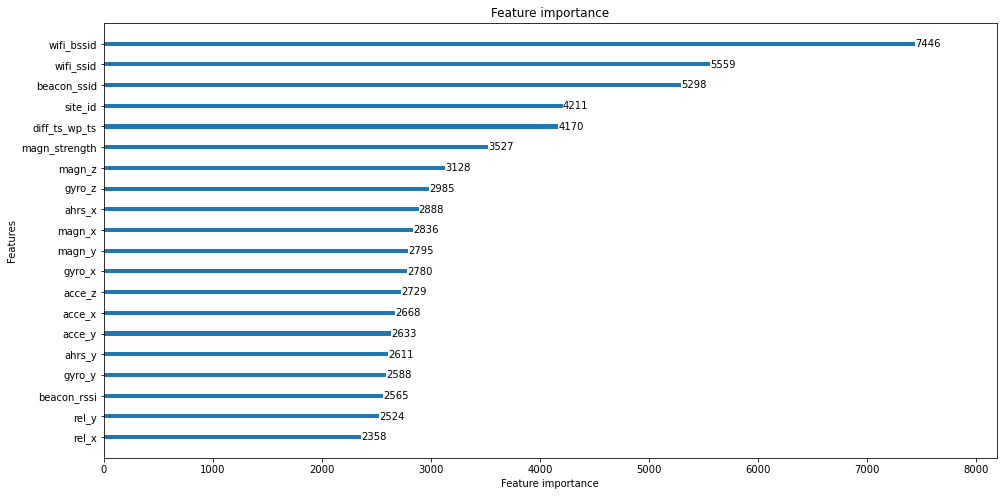

In [38]:
lgb.plot_importance(d["model_x"], max_num_features=20, grid=False, figsize=(16,8))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

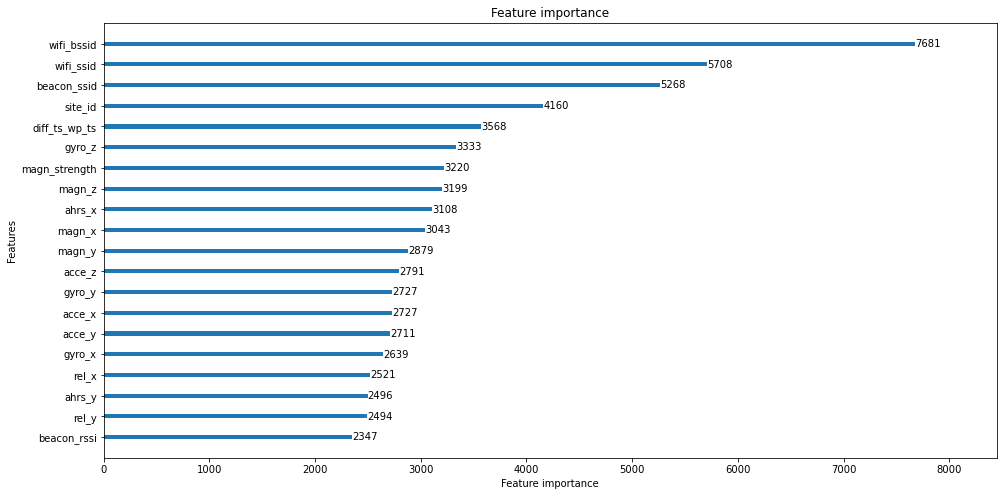

In [39]:
lgb.plot_importance(d["model_y"], max_num_features=20, grid=False, figsize=(16,8))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

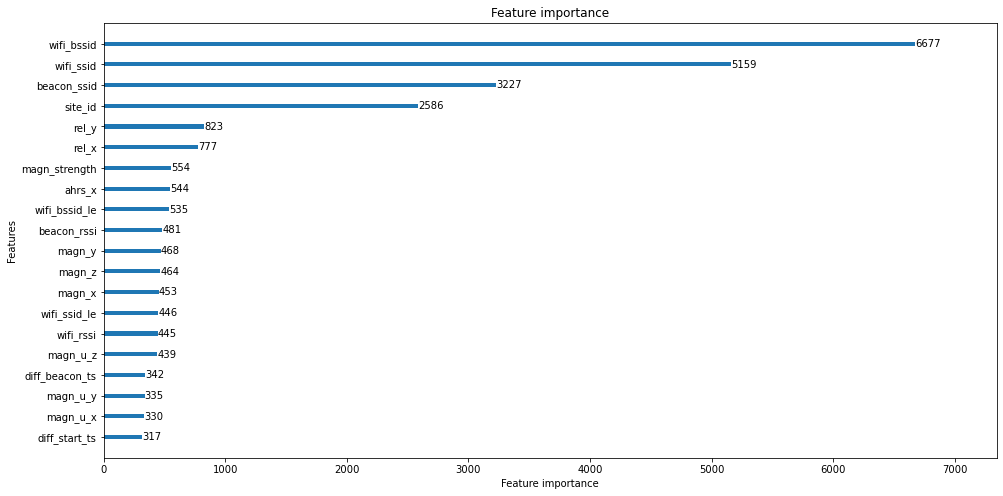

In [40]:
lgb.plot_importance(d["model_f"], max_num_features=20, grid=False, figsize=(16,8))

In [41]:
with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)

In [42]:
print(len(df_test.columns))
# df_test = df_test.dropna(axis=1, how='all')
df_test = df_test.dropna(axis=1, how='all')
df_test = df_test.dropna(axis=0, how='any')
print(len(df_test.columns))

null_cols = df_test.columns[df_test.isna().any()].tolist()
print("Columns with nulls: ", null_cols)

def fill_na_mean(df, cols, groupby_col):
    for col in cols:
        df[col] = df.groupby(groupby_col).transform(lambda x: x.fillna(x.mean()))

# 4 min for 100,000 rows
# fill_na_mean(df_test, tqdm(null_cols), "site_id")

# null_cols = df_test.columns[df_test.isna().any()].tolist()
# print("Check if nulls are filled: ", null_cols)


# column settings
# rename within_250ms and within_500ms first
df_test = df_test.rename({"within_250ms": "within_100ms", "within_500ms": "within_200ms"}, axis=1)

# latter is to drop all the ts related columns
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", "diff_start_wp_ts"]
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", \
#              "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
#              "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
#              "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
#              "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
#              "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
#              "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#              "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
#             ]

categorical_features = ["site_id", "within_100ms", "within_200ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
int_features = ["acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z",\
                "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z",\
                "wifi_rssi", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", 
                "beacon_rssi", "beacon_ts", "diff_beacon_ts", \
                "ts_date", "ts_day", "ts_hour", "ts_minute", \
                "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_test[col] = df_test[col].astype("category")

# convert to int from datetime64 dtype
for col in int_features:
    df_test[col] = df_test[col].astype(int)

# drop cols
drop_cols = ["file_id", "floor_le"]
df_test = df_test.drop(columns=drop_cols)
test_features = df_test.set_index("site_path_timestamp")

87
75
Columns with nulls:  []


In [49]:
print(len(df_test))
print("site_id nunique: ", df_test["site_id"].nunique(), "\n")
display(test_features.head())
print(len(features.columns))
print(len(test_features.columns))
no_overlap = set(features.columns) ^ set(test_features.columns)
# a = list(set(features.columns) & set(test_features.columns))
print(no_overlap)
# print(features.dtypes[:50])
# print(test_features.dtypes[:50])

229401
site_id nunique:  24 



,site_id,ts,start_ts,diff_start_ts,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_100ms,within_200ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
site_path_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,5a0546857ecc773753327266,136.0,0.0,136.0,9.0,9.0,127.0,False,True,136.0,136.0,0.798813,4.300720,7.810059,136.0,136.0,0.247101,0.104201,0.474897,136.0,136.0,30.561829,-1.228333,-38.301086,49.015379,136.0,136.0,-0.039139,-0.507996,-0.148392,136,136,0,4,8,136.0,136.0,34.687805,6.938171,-377.32544,136,136,0,0,0,2340,2340,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45,1578474544726,110,110,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-91,1144.0,1144.0,-0.425353,0.24869,0,6,1505,4141,2735,136000000,0,0,0,1578474544726000128,1578441600000000000,1578474000000000000,1578474540000000000
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,5a0546857ecc773753327266,156.0,0.0,156.0,9.0,9.0,147.0,False,True,156.0,156.0,0.026688,4.911835,7.244446,156.0,156.0,0.247101,0.104201,0.474897,156.0,156.0,29.173279,-1.922607,-36.950684,47.118252,156.0,156.0,-0.084946,-0.447800,-0.207520,156,156,0,4,7,156.0,156.0,33.299255,6.243896,-375.97504,156,156,0,0,0,2340,2340,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45,1578474544726,110,110,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-91,1144.0,1144.0,-0.425353,0.24869,0,6,1505,4141,2735,156000000,0,0,0,1578474544726000128,1578441600000000000,1578474000000000000,1578474540000000000
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,5a0546857ecc773753327266,176.0,0.0,176.0,9.0,9.0,167.0,False,True,176.0,176.0,-0.418640,5.354172,7.295914,176.0,176.0,0.254368,0.111510,0.452041,176.0,176.0,27.786255,-0.535583,-37.625122,46.776197,176.0,176.0,-0.110519,-0.327423,-0.163315,176,176,0,5,7,176.0,176.0,31.912231,7.630920,-376.64948,176,176,0,0,0,2340,2340,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45,1578474544726,216,216,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-71,1144.0,1144.0,-0.425353,0.24869,0,6,1505,4141,2735,176000000,0,0,0,1578474544726000128,1578441600000000000,1578474000000000000,1578474540000000000
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,5a0546857ecc773753327266,196.0,0.0,196.0,9.0,9.0,187.0,False,True,196.0,196.0,-0.540146,5.456512,7.113358,196.0,196.0,0.254368,0.111510,0.452041,196.0,196.0,27.786255,-0.535583,-36.950684,46.235439,196.0,196.0,-0.267639,-0.278961,-0.078094,196,196,0,5,7,196.0,196.0,31.912231,7.630920,-375.97504,196,196,0,0,0,2340,2340,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45,1578474544726,216,216,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-71,1144.0,1144.0,-0.425353,0.24869,0,6,1505,4141,2735,196000000,0,0,0,1578474544726000128,1578441600000000000,1578474000000000000,1578474540000000000
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,5a0546857ecc773753327266,216.0,0.0,216.0,9.0,9.0,207.0,False,False,216.0,216.0,-0.078064,5.031540,7.386291,216.0,216.0,0.256831,0.115168,0.441099,216.0,216.0,27.786255,-0.535583,-38.975525,47.869138,216.0,216.0,-0.461517,-0.306656,-0.005112,216,216,0,5,7,216.0,216.0,31.912231,7.630920,-377

72
72
set()


In [50]:
# Load models
modelx = d["model_x"]
modely = d["model_y"]
modelf = d["model_f"]

# Make predictions with test data
test_predsx = modelx.predict(test_features)
test_predsy = modely.predict(test_features)
test_predsf = modelf.predict(test_features)

In [51]:
df_preds = pd.DataFrame(np.stack((test_features.index, test_predsf, test_predsx, test_predsy))).T
df_preds.columns = ["site_path_timestamp", "floor", "x", "y"]
# test_preds = test_preds.set_index("site_path_timestamp")
print("df_preds before groupby: ")
display(df_preds.head())

# groupby to take the average
# convert to float from object
for col in ["floor", "x", "y"]:
    df_preds[col] = df_preds[col].astype(float)

df_pred_grouped = df_preds.groupby(["site_path_timestamp"]).mean()
df_pred_grouped = df_pred_grouped.reset_index()

# round floor value to integer
df_pred_grouped["floor"] = df_pred_grouped["floor"].round(decimals=0)

print("len of df_pred_grouped: ", len(df_pred_grouped)) # should be same as sub_df length, but not yet
print("df_pred_grouped after groupby: ")
display(df_pred_grouped.head())

# find the missing site_path_timestamp and fill it with average
# get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
print("sub_df: ")
display(sub_df.head())

subdf_site_id = sub_df["site_path_timestamp"].unique()
pred_site_id = df_pred_grouped["site_path_timestamp"].unique()
print("len of subdf_site_id", len(subdf_site_id), "\n")
print("len of pred_site_id", len(pred_site_id), "\n")
no_overlap = set(subdf_site_id) ^ set(pred_site_id)
print("no overlap", no_overlap)

# missing timestamps -> fill in with average value for now
# '5dbc1d84c1eb61796cf7c010_67bf4b03fc22542bb6d51daf_0000000000011'
# '5d2709e003f801723c32d896_e3455e53350336857caf08f0_0000000119903'
floor_avg = round(df_pred_grouped["floor"].mean())
x_avg = df_pred_grouped["x"].mean()
y_avg = df_pred_grouped["y"].mean()
print("avg values for floor, x, y", floor_avg, x_avg, y_avg)

for i, ts in enumerate(list(no_overlap)):
    row = [ts, floor_avg, x_avg, y_avg]
    row_num = len(df_pred_grouped)
    df_pred_grouped.loc[row_num + i] = row

print("len of pred_grouped", len(df_pred_grouped))
print("tail of df_pred_grouped to check missing two rows are appended: ")
display(df_pred_grouped.tail())

df_preds before groupby: 


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.450440,93.161088,51.402322
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.463484,93.467150,51.485315
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.414224,95.051751,50.239248
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.421377,96.064555,49.786406
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.418975,96.975386,50.716872


len of df_pred_grouped:  9638
df_pred_grouped after groupby: 


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,95.508816,50.623687
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,83.521887,45.124621
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,98.162585,42.733486
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,87.378413,56.120329
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,84.333144,50.645323


sub_df: 


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0


len of subdf_site_id 10133 

len of pred_site_id 9638 

no overlap {'5dbc1d84c1eb61796cf7c010_29579192e65ea7826a727c42_0000000075678', '5dbc1d84c1eb61796cf7c010_ee1f4765f6d48f2d405b52ba_0000000059615', '5dbc1d84c1eb61796cf7c010_47a960ef9f70f0b662d9d244_0000000043532', '5da138b74db8ce0c98bd4774_4c93f4e157d7e283547f1153_0000000104067', '5da138b74db8ce0c98bd4774_536134a5924bfa7840e315de_0000000063969', '5d2709c303f801723c3299ee_2e343fa6a9237d61d0f99ccc_0000000041342', '5d2709d403f801723c32bd39_07db4eec1fc8df5040d86602_0000000044665', '5dbc1d84c1eb61796cf7c010_47a960ef9f70f0b662d9d244_0000000011109', '5da1389e4db8ce0c98bd0547_df4798f4f3b3c5c510e237ad_0000000047703', '5d2709d403f801723c32bd39_07db4eec1fc8df5040d86602_0000000025952', '5da138b74db8ce0c98bd4774_240060212e4ee62beb701c5c_0000000013669', '5dbc1d84c1eb61796cf7c010_fd76cacb0312c4bd96701f09_0000000048456', '5dbc1d84c1eb61796cf7c010_e8ed3f22ef83d9515ce36e8f_0000000013618', '5d2709d403f801723c32bd39_07db4eec1fc8df5040d86602_0000000000

len of pred_grouped 10133
tail of df_pred_grouped to check missing two rows are appended: 


,site_path_timestamp,floor,x,y
10618,5d27097f03f801723c320d97_698dc1d1a1885908e8fbf...,2.0,95.030501,90.82878
10620,5d2709e003f801723c32d896_e83cee96a0e4c29297699...,2.0,95.030501,90.82878
10622,5dbc1d84c1eb61796cf7c010_e6fcb043744edde3b9f05...,2.0,95.030501,90.82878
10624,5d2709bb03f801723c32852c_854dedd673b748ac7a14c...,2.0,95.030501,90.82878
10626,5dbc1d84c1eb61796cf7c010_eb4de03a42f451c11ffec...,2.0,95.030501,90.82878


In [52]:
# csv for submission
df_pred_grouped.to_csv("submission.csv", index=False)

---
## Model 2
---

In [ ]:
# Prepare new d
d = {}

In [ ]:
# Try RF

# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'rf',
              'n_estimators': 50000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 10,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

In [ ]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

In [ ]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

In [ ]:
comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"], 
                          d["target_val_x"].to_numpy(), d["target_val_y"].to_numpy(), d["target_val_f"])

print("comp metric: ", comp_metric)

In [ ]:
# Visualize feature importance
lgb.plot_importance(d["model_x"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
lgb.plot_importance(d["model_y"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
lgb.plot_importance(d["model_f"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
# Try MLP
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

In [ ]:
# column settings
drop_cols = ["site_id", "file_id", "wifi_ssid", "wifi_bssid", \
             "floor_converted", "floor", "x", "y", "floor_le", \
             "acce_acc", "ahrs_acc", "magn_acc", "wifi_freq"]
datetime_features = ["ts_date", "ts_day", "ts_hour", "ts_minute", \
                     "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                     "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]
    
# convert to int from datetime64 dtype
for col in datetime_features:
    df_train[col] = df_train[col].astype(int)

# set features and labels
# print(df_train.info())

features = df_train.drop(columns=drop_cols)
target_x = df_train.iloc[:, 5]
target_y = df_train.iloc[:, 6]
target_f = df_train.iloc[:, 2]

targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = 42)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
#     d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
#     d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
#     print(d["train_{}".format(tgt)].get_data().shape)
#     print(d["train_{}".format(tgt)].get_label().shape)
#     print(d["val_{}".format(tgt)].get_data().shape)
#     print(d["val_{}".format(tgt)].get_label().shape)

In [ ]:
display(feat_train.head())
display(feat_val.head())
print(len(feat_train))
print(len(feat_val))
print(len(target_train))
print(len(target_val))
print(feat_train.shape)
print(feat_val.shape)

for tgt in targets:
    print(f"feat_train_{tgt}", d["feat_train_{}".format(tgt)].shape)
    print(f"feat_val_{tgt}", d["feat_val_{}".format(tgt)].shape)
    print(f"target_train_{tgt}", d["target_train_{}".format(tgt)].shape)
    print(f"target_val_{tgt}", d["target_val_{}".format(tgt)].shape)

In [ ]:
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_converted_le"]
# features = df_train.drop(columns=drop_cols)


In [ ]:
# Try MLP
# feat_train, feat_val, target_train, target_val

# hyper parameters
input_size = feat_train.shape[1]
print(input_size)
output_size = 1
num_epochs = 5000
learning_rate = 0.1


# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(d["feat_train_y"])
X_test = scaler.transform(d["feat_val_y"])

y_train = np.expand_dims(d["target_train_y"], axis=1)
y_test = np.expand_dims(d["target_val_y"], axis=1)

# linear regression model
class LinearRegression(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear_1 = nn.Linear(input_size, input_size)
        self.linear_2 = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.linear_1(x)
        out = self.linear_2(x)
        return out

model = LinearRegression(input_size, output_size)
print(model)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(X_train, y_train):
#     print("X: ", X_train[0])
#     print("X shape: ", X_train.shape)
#     print("y: ", y_train[0])
#     print("y shape: ", y_train.shape)
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).float()
#     print(inputs.shape)
#     print(targets.shape)

    optimizer.zero_grad()
    outputs = model(inputs)
#     print(outputs.shape)

    loss = torch.sqrt(criterion(outputs, targets)) # Use RMSE not MSE so we can compare with lgbm baseline
    loss.backward()
    optimizer.step()

    return loss.item()

def valid(X_test, y_test):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).float()
    
    outputs = model(inputs)
    val_loss = torch.sqrt(criterion(outputs, targets)) # Use RMSE not MSE
    
    return val_loss.item()
        
# train the model
loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    loss = train(X_train, y_train)
    val_loss = valid(X_test, y_test)
#     print(loss)
#     print(val_loss)

    if epoch % 200 == 0:
        print('epoch %d, loss: %.4f val_loss: %.4f' % (epoch, loss, val_loss))

    loss_list.append(loss)
    val_loss_list.append(val_loss)

# plot learning curve
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()

In [ ]:
# Run MLP prediction
# Calculate comp_metric score

In [ ]:
# # Load test data
# df_test_pred = df_test.drop(columns=drop_cols)

# # Add "site_path_timestamp" column to df_test
# # convert ts to unix and then convert it to string, and put it in a new column["ts_unix"]
# # join ["site_id", "file_id", "ts_unix"] and put it into a new column ["site_path_timestamp"]
# # or just add it when generating the data -> less steps -> less likely to make a mistake

# test_preds_x = model_x.predict(df_test_pred)
# test_preds_y = model_y.predict(df_test_pred)
# test_preds_f = model_f.predict(df_test_pred)

# # stack the results up with the pairing site_path_timestamp
# # load ssubm
# # test_preds = pd.concat([test_preds_x, test_preds_y, test_preds_f], axis=1)
# test_preds.columns = ssubm.columns
# test_preds.index = df_test_pred["site_path_timestamp"]
# test_preds["floor"] = test_preds["floor"].astype(int)
# predictions.append(test_preds)

In [ ]:
# generate prediction file 
# pd.concat(predictions)
# reindex the prediction df
# convert to csv for submission